In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

def duplicate_images_to_shape(batch_size: int, duplicate_count: int = 19):
    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Reshape to (60000, 28, 28, 1) for each image
    x_train = np.expand_dims(x_train, axis=-1)  # Shape becomes (60000, 28, 28, 1)
    x_test = np.expand_dims(x_test, axis=-1)    # Shape becomes (10000, 28, 28, 1)

    # Sample some data
    x_train = x_train[:batch_size]
    y_train = y_train[:batch_size]

    # Duplicate the image 19 times, resulting in shape (60000, 19, 28, 28, 1)
    x_train = np.repeat(np.expand_dims(x_train, axis=1), duplicate_count, axis=1)  # Shape becomes (60000, 19, 28, 28, 1)
    x_test = np.repeat(np.expand_dims(x_test, axis=1), duplicate_count, axis=1)    # Shape becomes (10000, 19, 28, 28, 1)

    # Normalize the images by dividing by 255
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    # Train-test split for validation data (80% train, 20% validation)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    return x_train, y_train, x_val, y_val, x_test, y_test

# Example usage
batch_size = 900  # You can change the batch size
x_train, y_train, x_val, y_val, x_test, y_test = duplicate_images_to_shape(batch_size)

# Verify the shapes
print(f'x_train shape: {x_train.shape}')  # Should print (48000, 19, 28, 28, 1)
print(f'y_train shape: {y_train.shape}')  # Should print (48000,)
print(f'x_val shape: {x_val.shape}')      # Should print (12000, 19, 28, 28, 1)
print(f'y_val shape: {y_val.shape}')      # Should print (12000,)
print(f'x_test shape: {x_test.shape}')    # Should print (10000, 19, 28, 28, 1)
print(f'y_test shape: {y_test.shape}')    # Should print (10000,)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (720, 19, 28, 28, 1)
y_train shape: (720,)
x_val shape: (180, 19, 28, 28, 1)
y_val shape: (180,)
x_test shape: (10000, 19, 28, 28, 1)
y_test shape: (10000,)


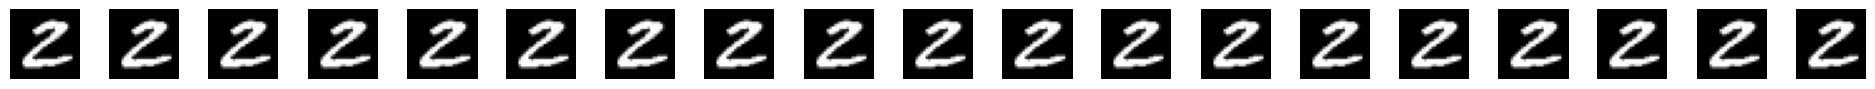

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_slices(sample: np.ndarray):
    """
    Plots all 19 slices of a given sample in a row grid.

    Args:
        sample (np.ndarray): A single sample with shape (19, 28, 28, 1).
                              The sample should have 19 slices, each of shape (28, 28, 1).
    """
    # Ensure sample has the correct shape
    assert sample.shape == (19, 28, 28, 1), "Sample must have shape (19, 28, 28, 1)"

    # Create a figure with 19 subplots in a single row
    fig, axes = plt.subplots(1, 19, figsize=(19, 1))

    for i in range(19):
        # Extract the 28x28 slice for each of the 19 duplicated images
        slice_image = sample[i, :, :, 0]  # Shape: (28, 28)

        # Plot the slice image
        axes[i].imshow(slice_image, cmap='gray')
        axes[i].axis('off')  # Hide axes for better visualization

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage
# Let's assume `sample` is a single sample from your dataset, with shape (19, 28, 28, 1)
# sample = np.random.rand(19, 28, 28, 1)  # Random example, replace with actual data

plot_slices(x_train[np.random.randint(0, len(x_train))])

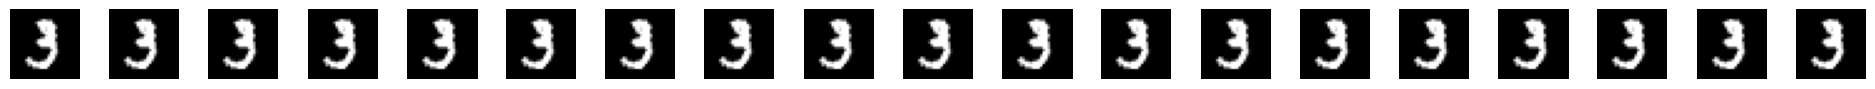

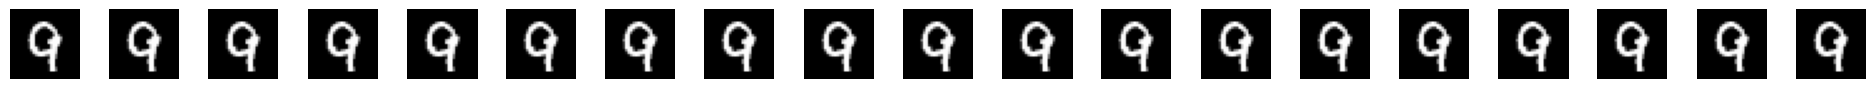

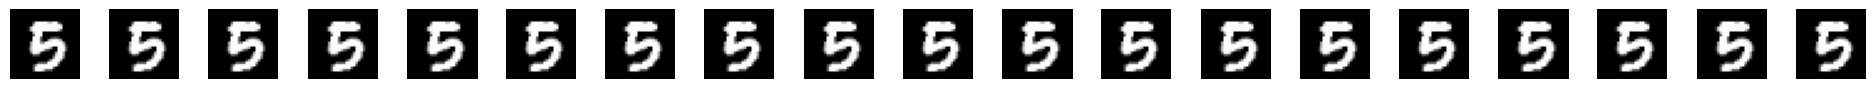

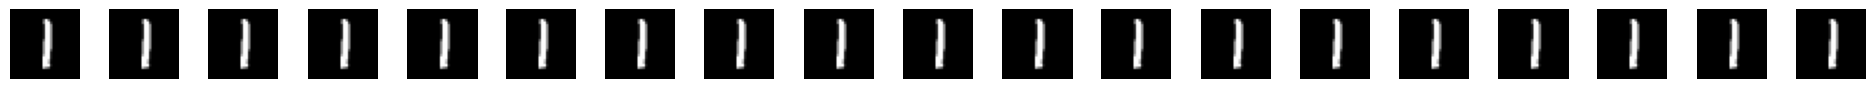

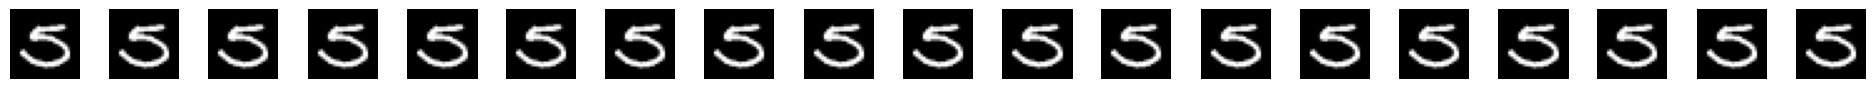

In [3]:
for i in range(5):
    plot_slices(x_train[i])

In [4]:
from typing import Optional, Tuple, Union
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Conv2D

class CustomConv2D(Conv2D):
    """
    A custom 2D convolution layer that applies a softmax activation
    along the channel dimension after performing the convolution.

    This layer inherits from `tf.keras.layers.Conv2D` and overrides the
    `call` method to pass the convolution output through a softmax function.

    Args:
        filters: Integer, the dimensionality of the output space
                 (i.e. the number of filters in the convolution).
        kernel_size: An integer or tuple/list of 2 integers, specifying the
                     height and width of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers, specifying the strides
                 of the convolution along the height and width.
                 (default: (1, 1))
        padding: One of "valid" or "same" (case-insensitive).
                 (default: "valid")
        data_format: A string, one of "channels_last" or "channels_first".
                     (default: "channels_last")
        dilation_rate: An integer or tuple/list of 2 integers, specifying
                       the dilation rate to use for dilated convolution.
                       (default: (1, 1))
        activation: Activation function not needed here as we will apply softmax
                    manually.
        use_bias: Boolean, whether the layer uses a bias vector.
                  (default: True)
        kernel_initializer: Initializer for the kernel weights matrix.
        bias_initializer: Initializer for the bias vector.
        kernel_regularizer: Regularizer function applied to the kernel weights matrix.
        bias_regularizer: Regularizer function applied to the bias vector.
        activity_regularizer: Regularizer function applied to the output of the layer.
        kernel_constraint: Constraint function applied to the kernel matrix.
        bias_constraint: Constraint function applied to the bias vector.
    """

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Call method that performs the convolution and then applies a softmax
        along the channel dimension.

        Args:
            inputs: A 4D tensor with shape
                    (batch_size, height, width, channels) if data_format='channels_last'.

        Returns:
            A 4D tensor of the same shape as `inputs`, after the convolution
            and softmax activation.
        """
        # Perform the standard convolution
        x = super().call(inputs)
        # Apply softmax along the channel dimension
        # Assuming channels_last format, softmax is applied along axis = -1
        x = tf.nn.softmax(x, axis=-1)
        return x

In [5]:
from tensorflow.keras import layers, models, optimizers, losses, regularizers
import tensorflow as tf

def naive_spatial_attention(inputs: tf.Tensor) -> tf.Tensor:
    """
    Applies a naive spatial attention by averaging across spatial dimensions
    and using a dense layer to produce a spatial attention map.
    """
    attention = layers.GlobalAveragePooling3D()(inputs)
    attention = layers.Dense(1, activation='sigmoid')(attention)
    return layers.multiply([inputs, attention])

class PatchEmbeddingLayer(layers.Layer):
    """
    A custom layer that applies a convolution to emulate patch extraction,
    and then applies a learnable embedding projection (another convolution)
    to produce a trainable embedded representation.

    This layer:
    - Takes input of shape (b, t, h, w, c).
    - Applies a TimeDistributed Conv2D to extract patch-like features.
    - Applies a TimeDistributed 1x1 Conv2D to produce a trainable embedding.
    - Outputs (b, t, h, w, filters).
    """

    def __init__(self, filters: int = 48, kernel_size: int = 5, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        # These will be built once input shape is known
        self.patch_conv = None
        self.embedding_conv = None

    def build(self, input_shape):
        # input_shape is (b, t, h, w, c)
        # We'll create patch-based convolution: a small kernel to emulate patch extraction
        # Here, kernel_size=5 is arbitrary; you can adjust as needed.
        self.patch_conv = layers.TimeDistributed(
            CustomConv2D(
                filters=self.filters,
                kernel_size=(self.kernel_size, self.kernel_size),
                padding='same',
                activation='relu',
                kernel_regularizer=regularizers.l2(1e-5)
            )
        )

        # Another TimeDistributed Conv2D with kernel_size=1 to act as a learnable embedding
        self.embedding_conv = layers.TimeDistributed(
            CustomConv2D(
                filters=self.filters,
                kernel_size=(1, 1),
                activation='linear',
                kernel_regularizer=regularizers.l2(1e-5)
            )
        )
        super().build(input_shape)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        # x: (b, t, h, w, c)
        x = self.patch_conv(x)      # (b, t, h, w, filters)
        x = self.embedding_conv(x)  # (b, t, h, w, filters)
        return x

def build_model(input_shape: tuple[int, int, int, int, int], num_spatial_block: int = 2) -> tf.keras.Model:
    """
    Builds a model for next frame prediction using a U-Net style architecture.
    Instead of ConvLSTM2D, we use a PatchEmbeddingLayer that applies a convolution
    to extract patch-like features and then a trainable embedding projection.

    Args:
        input_shape: (time, height, width, channels).
        num_spatial_block: Number of spatial blocks in the encoder and decoder.

    Returns:
        A Keras Model object.
    """
    inp = layers.Input(shape=input_shape)

    encoder_outputs = []
    x = inp
    for i in range(num_spatial_block):
        # Use PatchEmbeddingLayer instead of ConvLSTM2D
        x = PatchEmbeddingLayer(filters=48, kernel_size=5)(x)
        x = naive_spatial_attention(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        encoder_outputs.append(x)

    # Bottleneck layer (using PatchEmbeddingLayer instead of ConvLSTM2D)
    x = PatchEmbeddingLayer(filters=64, kernel_size=5)(x)
    x = naive_spatial_attention(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Decoder path
    for i in reversed(range(num_spatial_block)):
        x = PatchEmbeddingLayer(filters=48, kernel_size=5)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Concatenate()([x, encoder_outputs[i]])
        x = layers.Dropout(0.2)(x)

    # Final Conv3D layer for spatiotemporal output
    x = layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    )(x)

    model = models.Model(inputs=inp, outputs=x)
    return model

In [6]:
import keras

In [7]:
%%time

# Define model: vid2vid
num_spatial_block = 2
model = build_model(input_shape=(None, *x_train.shape[2:]), num_spatial_block=num_spatial_block)

# Compile
lr = 1e-4
wd = 1e-4
cv = 1.0
optimizer = optimizers.AdamW(learning_rate=lr, weight_decay=wd, clipvalue=cv)
model.compile(
    loss=losses.binary_crossentropy,
    optimizer=optimizer,
)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=3, verbose=1)

# Define modifiable training hyperparameters.
epochs = 300
batch_size = 4

# with tf.device('/device:GPU:0'):
# Fit the model to the training data.
model.fit(
    x_train,
    x_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, x_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/300
180/180 ━━━━━━━━━━━━━━━━━━━━ 93s 204ms/step - loss: 0.6426 - val_loss: 0.4278 - learning_rate: 1.0000e-04
Epoch 2/300
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - loss: 0.3833 - val_loss: 0.3929 - learning_rate: 1.0000e-04
Epoch 3/300
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - loss: 0.2749 - val_loss: 0.4506 - learning_rate: 1.0000e-04
Epoch 4/300
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - loss: 0.1693 - val_loss: 0.2431 - learning_rate: 1.0000e-04
Epoch 5/300
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - loss: 0.1374 - val_loss: 0.1236 - learning_rate: 1.0000e-04
Epoch 6/300
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - loss: 0.1129 - val_loss: 0.1178 - learning_rate: 1.0000e-04
Epoch 7/300
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - loss: 0.0956 - val_loss: 0.0947 - learning_rate: 1.0000e-04
Epoch 8/300
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - loss: 0.0863 - val_loss: 0.0875 - learning_rate: 1.0000e-04
Epoch 9/300
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step 

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, 28, 28,   │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_embedding_layer     │ (None, None, 28, 28,   │          3,600 │ input_layer[0][0]      │
│ (PatchEmbeddingLayer)     │ 48)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling3d  │ (None, 48)             │              0 │ patch_embedding_layer… │
│ (GlobalAveragePooling3D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │             49 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, None, 28, 28,   │              0 │ patch_embedding_layer… │
│                           │ 48)                    │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, 28, 28,   │            192 │ multiply[0][0]         │
│ (BatchNormalization)      │ 48)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, None, 28, 28,   │              0 │ batch_normalization[0… │
│                           │ 48)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_embedding_layer_1   │ (None, None, 28, 28,   │         60,000 │ dropout[0][0]          │
│ (PatchEmbeddingLayer)     │ 48)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling3d… │ (None, 48)             │              0 │ patch_embedding_layer… │
│ (GlobalAveragePooling3D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             49 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, None, 28, 28,   │              0 │ patch_embedding_layer… │
│                           │ 48)                    │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, 28, 28,   │            192 │ multiply_1[0][0]       │
│ (BatchNormalization)      │ 48)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, 28, 28,   │              0 │ batch_normalization_1… │
│                           │ 48)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_embedding_layer_2   │ (None, None, 28, 28,   │         81,024 │ dropout_1[0][0]        │
│ (PatchEmbeddingLayer)

 Total params: 1,034,590 (3.95 MB)

 Trainable params: 344,692 (1.31 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 689,386 (2.63 MB)

In [9]:
y_val_pred = model.predict(x_val)
print(y_val_pred.shape)

6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step
(180, 19, 28, 28, 1)


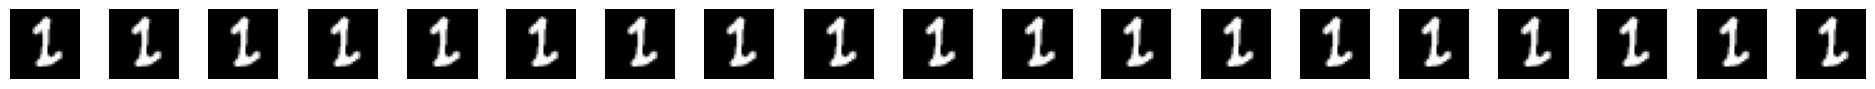

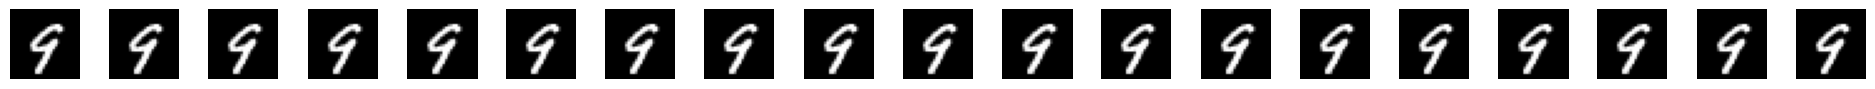

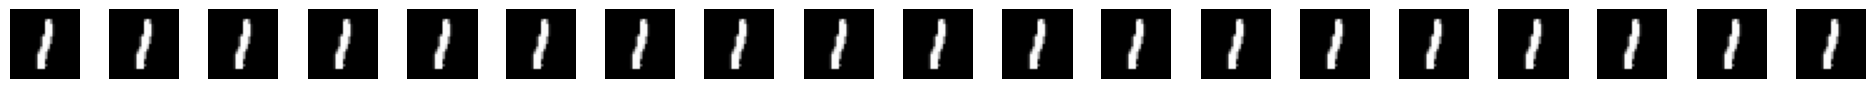

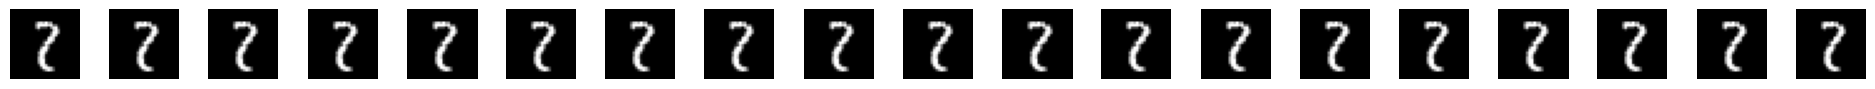

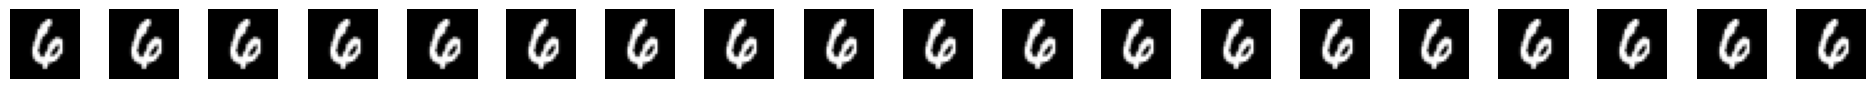

In [12]:
for i in range(5):
    plot_slices(x_val[i])

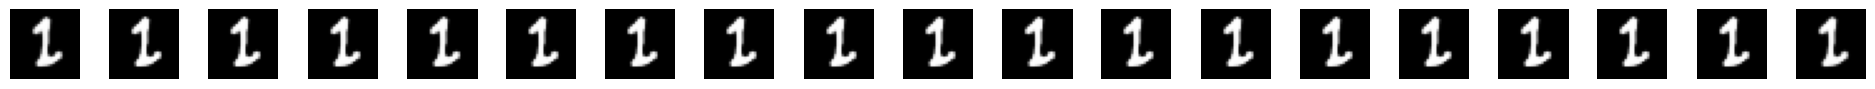

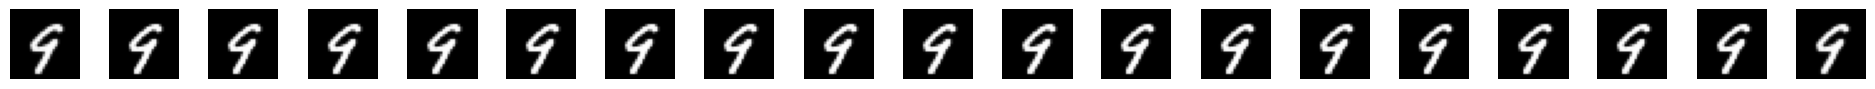

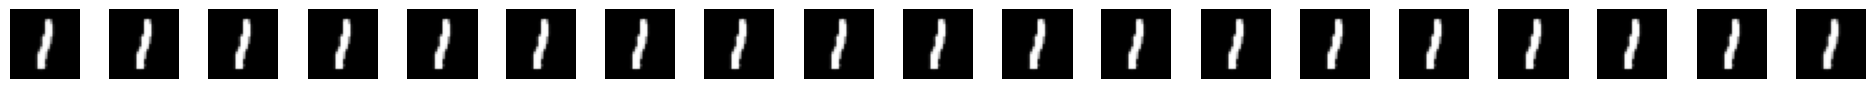

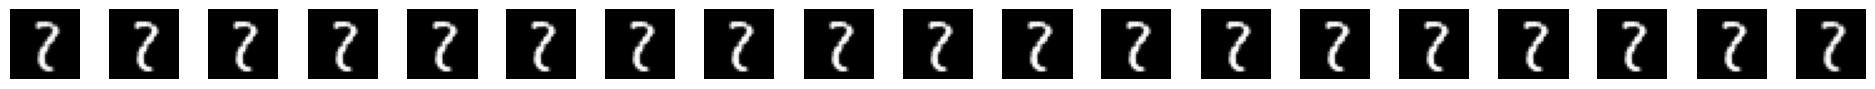

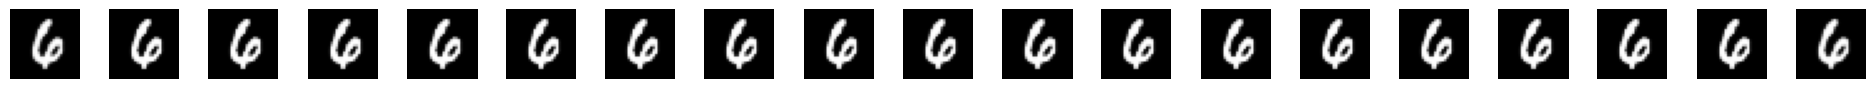

In [10]:
for i in range(5):
    plot_slices(y_val_pred[i])

In [18]:
model.get_layer('dense_')

ValueError: No such layer: dense_. Existing layers are: ['input_layer', 'patch_embedding_layer', 'global_average_pooling3d', 'dense', 'multiply', 'batch_normalization', 'dropout', 'patch_embedding_layer_1', 'global_average_pooling3d_1', 'dense_1', 'multiply_1', 'batch_normalization_1', 'dropout_1', 'patch_embedding_layer_2', 'global_average_pooling3d_2', 'dense_2', 'multiply_2', 'batch_normalization_2', 'dropout_2', 'patch_embedding_layer_3', 'batch_normalization_3', 'concatenate', 'dropout_3', 'patch_embedding_layer_4', 'batch_normalization_4', 'concatenate_1', 'dropout_4', 'conv3d'].

In [21]:
x_train.shape

(720, 19, 28, 28, 1)

In [23]:
import tensorflow as tf

# Assuming you have your model and x_train
# For example, let's assume your model is already defined and compiled
# model = your_predefined_model
# x_train = your_input_data

# Get the 'dense_1' layer
dense_1_layer = model.get_layer('global_average_pooling3d_2')

# Create a new model that outputs the output of 'dense_1' layer
intermediate_model = tf.keras.Model(inputs=model.input, outputs=dense_1_layer.output)

# Now, you can feed x_train into this new model to get the output of 'dense_1'
batch_size = 32  # or even lower if necessary
dense_1_output = intermediate_model(x_train[:batch_size])  # Process one batch at a time

# dense_1_output will now contain the output of the 'dense_1' layer
print(dense_1_output.shape)  # You can inspect the shape of the output

(32, 64)
